In [ ]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sb
import time
#from ipywidgets import interact, fixed
pd.set_option('display.float_format', lambda x: '%.2f' % x)

from libs.CovidDatasets import JHUDataset as LegacyJHUDataset
from libs.datasets import JHUDataset
from libs.datasets import FIPSPopulation
from libs.datasets import DHBeds
from libs.datasets.dataset_utils import AggregationLevel

from libs.ModelRun import ModelRun, prep_plot, report_months, plot_actuals

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
min_date = pd.to_datetime(datetime.datetime(2020, 1, 1))
epi_model = 'asymp'

beds_data = DHBeds.local().beds()
population_data = FIPSPopulation.local().population()

In [ ]:
timeseries = JHUDataset.local().timeseries()

In [6]:
test = ModelRun('NY')
test.get_data_subset(beds_data, population_data, timeseries, min_date)
test.set_epi_model('asymp')

In [7]:
test.epi_run.EpiParameters.generate_r0()

3.147999999999998

In [8]:
test.epi_run.InitConditions.mild

164768.75

In [9]:
test.run()

/Users/trae/.virtualenvs/covid-data-model/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/trae/.virtualenvs/covid-data-model/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


first case
2020-03-02 00:00:00
peak in hospitalizations
2020-05-08T00:00:00.000000000
225,485.84633933057
peak in icu
2020-05-15T00:00:00.000000000
44,921.30690922097
deaths
90,877.28548492682


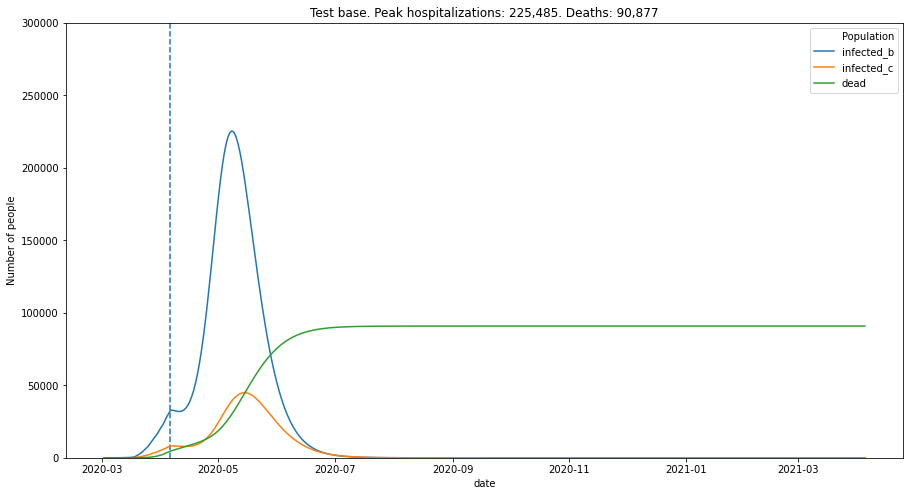

In [10]:
cols = ["infected_b", "infected_c", "dead"]

prep_plot(test.epi_run.display_df, cols, 'Test base', 300000)

In [11]:
test.epi_run.display_df['source'].value_counts()

base run    365
actuals      35
Name: source, dtype: int64

In [ ]:
print(test.epi_run.InitConditions.mild)
print(test.epi_run.InitConditions.hospitalized)
print(test.epi_run.InitConditions.icu)
print(test.epi_run.InitConditions.asymp)

In [ ]:
print(test.epi_run.model_run.hospitalization_rate)
print(test.epi_run.model_run.hospitalized_cases_requiring_icu_care)

In [ ]:
test.epi_run.InitConditions.mild = test.epi_run.InitConditions.mild * 3

In [ ]:
print(test.epi_run.InitConditions.mild)

In [ ]:
test.run()

In [ ]:
cols = ["infected_b", "infected_c", "dead"]

prep_plot(test.epi_run.display_df, cols, f'Base-case exposed to infected = {str(test.exposed_infected_ratio)}', 300000)

In [ ]:
# reload
test.reload_params()

# change inital condition params
test.exposed_infected_ratio = 3
test.model_cases = "divided_into_infected"

print(test.epi_run.EpiParameters.generate_r0())

In [ ]:
test.run()

first case
2020-04-05 00:00:00
peak in hospitalizations
2020-05-16T00:00:00.000000000
156,082.63530650997
peak in icu
2020-05-23T00:00:00.000000000
32,848.63654237578
deaths
82,355.28982473357


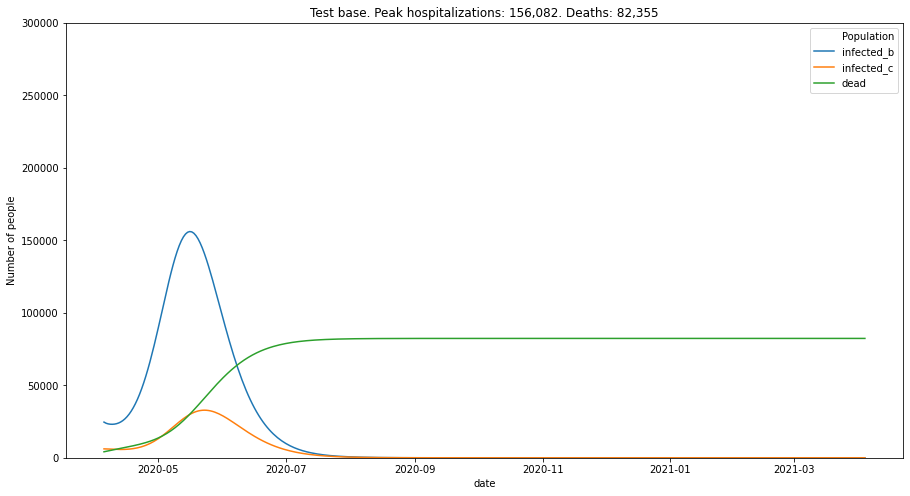

In [16]:
cols = ["infected_b", "infected_c", "dead"]

prep_plot(test.epi_run.display_df, cols, 'Test base', 300000)

In [17]:
school = {
    'name': 'school',
    'start_date': pd.to_datetime(datetime.datetime(2020, 4, 4)),
    'intervention_start_date': pd.to_datetime(datetime.datetime(2020, 3, 18)),
    'new_parameters': {
        'beta': 0.2,
        'beta_asymp': 0.2,
    },
    'type': 'past-actual',
}

test.add_intervention(school)

stay_at_home = {
    'name': 'stay_at_home',
    'start_date': pd.to_datetime(datetime.datetime(2020, 4, 4)),
    'intervention_start_date': pd.to_datetime(datetime.datetime(2020, 3, 22)),
    'new_parameters': {
        'beta': 0.15,
        'beta_asymp': 0.15,
    },
    'type': 'past-actual',
}

test.add_intervention(stay_at_home)

In [18]:
print(test.interventions['intervention_NY_school'].EpiParameters.generate_r0())
print(test.interventions['intervention_NY_stay_at_home'].EpiParameters.generate_r0())

1.3480000000000003
1.0479999999999998


In [25]:
test.run_all_interventions()

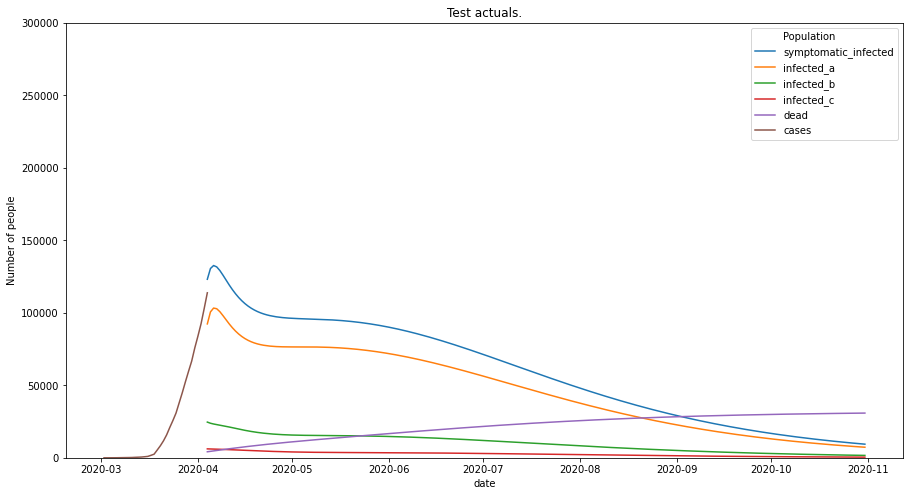

In [26]:
cols = ["symptomatic_infected", "infected_a", "infected_b", "infected_c", "dead"]

test_df = test.interventions['intervention_NY_stay_at_home'].display_df.copy()
test_actuals_df = test.actuals.copy()

end_date = datetime.datetime(2020, 11, 1)

test_df['symptomatic_infected'] = test_df.infected_a + test_df.infected_b + test_df.infected_c

test_df = test_df.loc[(test_df['date'] < end_date), :]

plot_actuals(test_df, test_actuals_df, cols, 'Test actuals', 300000 )

In [29]:
lift_early = {
    'name': 'lift_early',
    'start_date': pd.to_datetime(datetime.datetime(2020, 4, 9)),
    'intervention_start_date': pd.to_datetime(datetime.datetime(2020, 4, 9)),
    'new_parameters': {
        'beta': 0.25,
        'beta_asymp': 0.25,
    },
    'type': 'intervention',
}

test.add_intervention(lift_early)

test.run_intervention('intervention_NY_lift_early')

In [30]:
test.interventions['intervention_NY_lift_early'].EpiParameters.generate_r0()

1.6480000000000001

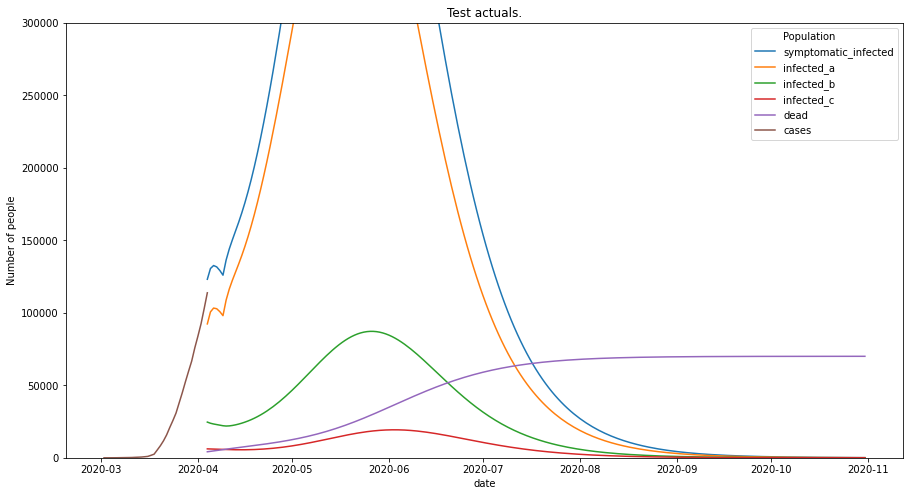

In [31]:
cols = ["symptomatic_infected", "infected_a", "infected_b", "infected_c", "dead"]

test_df = test.interventions['intervention_NY_lift_early'].display_df.copy()
test_actuals_df = test.actuals.copy()

end_date = datetime.datetime(2020, 11, 1)

test_df['symptomatic_infected'] = test_df.infected_a + test_df.infected_b + test_df.infected_c

test_df = test_df.loc[(test_df['date'] < end_date), :]

plot_actuals(test_df, test_actuals_df, cols, 'Test actuals', 300000 )

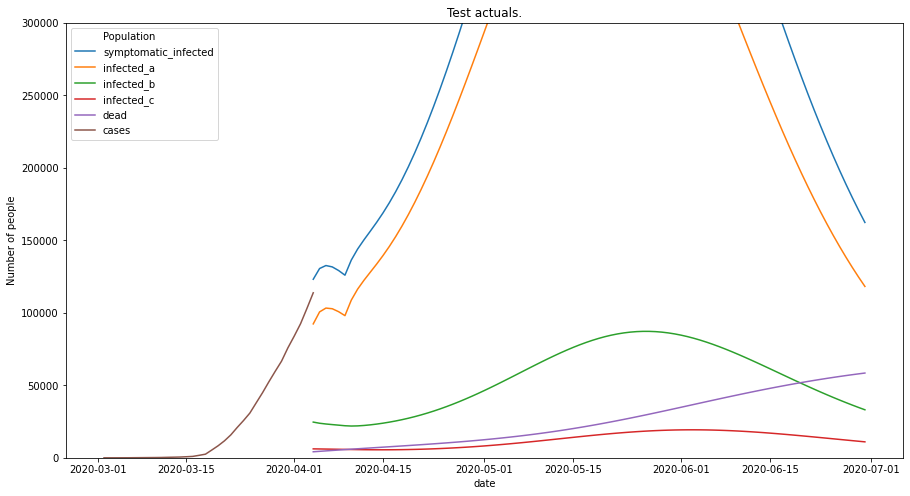

In [32]:
cols = ["symptomatic_infected", "infected_a", "infected_b", "infected_c", "dead"]

test_df = test.interventions['intervention_NY_lift_early'].display_df.copy()
test_actuals_df = test.actuals.copy()

end_date = datetime.datetime(2020, 7, 1)

test_df['symptomatic_infected'] = test_df.infected_a + test_df.infected_b + test_df.infected_c

test_df = test_df.loc[(test_df['date'] < end_date), :]

plot_actuals(test_df, test_actuals_df, cols, 'Test actuals', 300000 )

first case
2020-04-04 00:00:00
peak in hospitalizations
2020-05-26T00:00:00.000000000
87,222.07290328374
peak in icu
2020-06-03T00:00:00.000000000
19,313.354118027608
deaths
70,026.30872532801


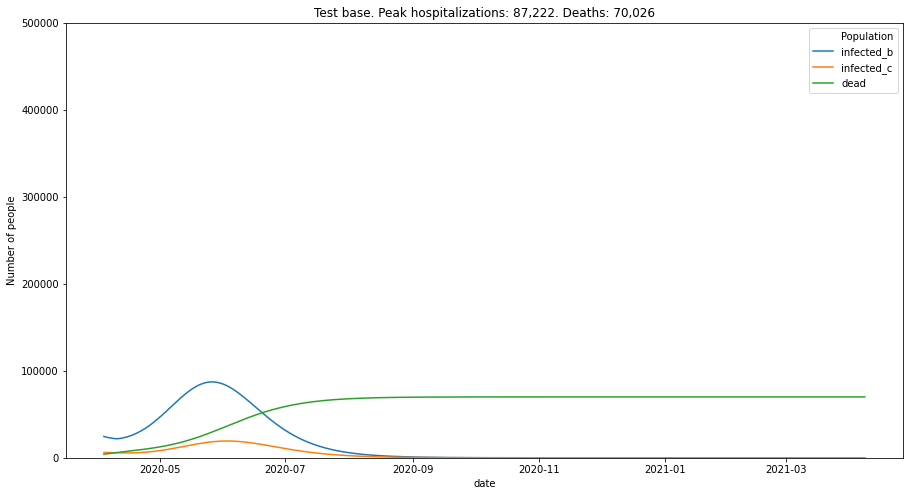

In [33]:
cols = ["infected_b", "infected_c", "dead"]

prep_plot(test.interventions['intervention_NY_lift_early'].display_df, cols, 'Test base', 500000)

In [4]:
state_list = ['AL', 'AK', 'AS', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'GU', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY',
              'LA', 'ME', 'MD', 'MH', 'MA', 'MI', 'FM', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'MP', 
              'OH', 'OK', 'OR', 'PW', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'VI', 'WA', 'WV', 'WI', 'WY']

In [5]:
print(len(state_list))

bad_list = ['AS', 'GU', 'MH', 'FM', 'MP', 'PW','VI']

state_list = [state for state in state_list if state not in bad_list]

print(len(state_list))

59
52


In [8]:
#model_runs = {}

#for state in state_list:
#    model_runs[state] = ModelRun(state)

#    model_runs[state].get_data_subset(beds_data, population_data, timeseries, 'USA', state, min_date)
#    model_runs[state].set_epi_model(epi_model)